# 🧪 Custom kNN Classification With KD Trees

In this notebook, we implement kNN with kd trees **from scratch**. We then compare the performance of these implementations with **scikit-learn**'s `KNeighborsClassifier` model.

### ⚙️ Importing Libraries & Environment Setup

In [1]:
import heapq
from math import ceil
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from numpy.typing import NDArray
from sklearn.datasets import make_classification
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [2]:
%matplotlib inline

pd.set_option("display.width", 150)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", None)

### 🧰 Utility Functions

In [3]:
def evaluate_classification_models(
    predictions: dict[str, NDArray[np.float64]], y: NDArray[np.float64]
) -> pd.DataFrame:
    """Evaluate multiple classification model predictions on the provided dataset.

    Args:
        predictions (dict[str, NDArray[np.float64]]): Dictionary mapping model names
            to predicted target arrays (binary or probabilities) for the dataset.
        y (NDArray[np.float64]): True binary target values of shape (n_samples,).

    Returns:
        pd.DataFrame: DataFrame containing classification metrics — Accuracy, Precision,
            Recall and F1-score — for each model. Columns correspond to
            model names, rows correspond to the metric names.
    """
    evaluations = pd.DataFrame(
        columns=predictions.keys(),
        index=["Accuracy", "Precision", "Recall", "F1-score"],
    )

    for name, y_pred in predictions.items():
        accuracy = accuracy_score(y, y_pred)
        precision = precision_score(y, y_pred, average="weighted")
        recall = recall_score(y, y_pred, average="weighted")
        f1 = f1_score(y, y_pred, average="weighted")

        evaluations.loc[:, name] = [accuracy, precision, recall, f1]

    return evaluations.astype(float)

In [ ]:
def plot_confusion_matrices(
    predictions: dict[str, NDArray[np.int64]],
    y_true: NDArray[np.int64],
    n_cols: int = 2,
) -> None:
    """Plot confusion matrices for multiple classification models.

    Each confusion matrix compares the true labels to predictions from one model.
    The plots are arranged in a grid layout for easy comparison.

    Args:
        predictions (dict[str, NDArray[np.int64]]): A dictionary mapping model names to
            their predicted labels (1D array of shape (n_samples,)).
        y_true (NDArray[np.int64]): True class labels (1D array of shape (n_samples,)).
        n_cols (int): Number of columns in the subplot grid layout.
            Default is 2.
    """
    n_models = len(predictions)
    n_cols = min(n_models, n_cols)
    n_rows = ceil(n_models / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
    axes = np.array(axes).reshape(-1)

    for ax, (name, y_pred) in zip(axes, predictions.items(), strict=False):
        conf_matrix = confusion_matrix(y_true, y_pred)
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
        ax.set_xlabel("Predicted Labels")
        ax.set_ylabel("True Labels")
        ax.set_title(name)

    for i in range(n_models, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

In [5]:
def plot_classification_boundaries(
    models: dict[str, Any],
    X_train: NDArray[np.float64],
    y_train: NDArray[np.float64],
    n_cols: int = 2,
) -> None:
    """Visualize boundaries of traine models.

    Args:
        models (dict[str, Any]): Dictionary of trained models with `.predict` method.
        X_train (NDArray[np.float64]): Training features of shape (n_samples, 2).
        y_train (NDArray[np.float64]): Training labels of shape (n_samples,).
        n_cols (int): Number of columns in subplot grid.
    """
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]

    n_models = len(models)
    n_cols = min(n_models, n_cols)
    n_rows = ceil(n_models / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
    axes = np.array(axes).reshape(-1)

    for ax, (name, model) in zip(axes, models.items(), strict=False):
        Z = model.predict(grid).reshape(xx.shape)

        ax.contourf(xx, yy, Z, alpha=0.3, cmap="Set1")
        sns.scatterplot(
            x=X_train[:, 0], y=X_train[:, 1], c=y_train, cmap="Set1", alpha=0.5, ax=ax
        )
        ax.set_xlabel("Feature 1")
        ax.set_ylabel("Feature 2")
        ax.set_title(name)

    for i in range(n_models, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

### 📥 Loading the Dataset

In [6]:
# Generate dataset
X, y = make_classification(
    n_samples=1000,
    n_features=2,
    n_informative=2,
    n_classes=4,
    n_clusters_per_class=1,
    n_redundant=0,
    class_sep=1.8,
    random_state=42,
)

In [7]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### 🧠 Implementing Custom Model Algorithms

In [ ]:
class Node:
    """KD-Tree node representing a point, its label, and splitting axis.

    Attributes:
        point (NDArray[np.float64]): The data point stored at this node.
        label (float): The label associated with the data point.
        axis (int): The axis along which the data is split at this node.
        left (Optional[Node]): Left child node.
        right (Optional[Node]): Right child node.
    """

    def __init__(self, point: NDArray[np.float64], label: float, axis: int) -> None:
        """Initialize a KD-Tree node.

        Args:
            point (NDArray[np.float64]): Data point stored in this node.
            label (float): Label associated with the data point.
            axis (int): Axis on which the data is split at this node.
        """
        self.point = point
        self.axis = axis
        self.label = label

        self.left: "Node" | None = None
        self.right: "Node" | None = None


class KDTree:
    """KD-Tree data structure for efficient nearest neighbor search in k-dim space.

    Attributes:
        k (int): Number of features (dimensions).
        root (Optional[Node]): Root node of the KD-Tree.
        p (float): Order of Minkowski distance used for distance calculations.
    """

    def __init__(
        self, points: NDArray[np.float64], labels: NDArray[np.float64], p: float = 2.0
    ) -> None:
        """Construct KD-Tree from points and labels.

        Args:
            points (NDArray[np.float64]): Array of points to build the tree from,
                shape (n_samples, n_features).
            labels (NDArray[np.float64]): Corresponding labels for each point.
            p (float, optional): Order of Minkowski distance to use
                (default is 2 for Euclidean).
        """
        self.k = points.shape[1] if points.size else 0
        self.p = p

        self.root: Node = self.build(points, labels)

    def _minkowski_metric(
        self, a: NDArray[np.float64], b: NDArray[np.float64], p: float = 2.0
    ) -> float:
        """Calculate Minkowski distance of order p between two points.

        Args:
            a (NDArray[np.float64]): First point.
            b (NDArray[np.float64]): Second point.
            p (float): Order of the Minkowski distance.

        Returns:
            float: Minkowski distance between points a and b.
        """
        return np.sum(np.abs(a - b) ** p) ** (1 / p)

    def build(
        self, points: NDArray[np.float64], labels: NDArray[np.float64], depth: int = 0
    ) -> Node | None:
        """Recursively build KD-Tree from data points and labels.

        Args:
            points (NDArray[np.float64]): Data points to build the tree with.
            labels (NDArray[np.float64]): Corresponding labels for points.
            depth (int, optional): Current depth in the tree used to select axis.
                Defaults to 0.

        Returns:
            Node | None: Root node of the KD-Tree (or subtree).
        """
        if points.shape[0] == 0:
            return None

        axis = depth % self.k
        sorted_idx = points[:, axis].argsort()
        sorted_points = points[sorted_idx]
        sorted_labels = labels[sorted_idx]
        median_idx = len(sorted_points) // 2

        node = Node(sorted_points[median_idx], sorted_labels[median_idx], axis)
        node.left = self.build(
            sorted_points[:median_idx], sorted_labels[:median_idx], depth + 1
        )
        node.right = self.build(
            sorted_points[median_idx + 1 :], sorted_labels[median_idx + 1 :], depth + 1
        )

        return node

    def search_k_nearest_neighbors(
        self,
        point: NDArray[np.float64],
        k: int,
        node: Node | None = None,
        depth: int = 0,
        best_heap: list[tuple[float, Node]] | None = None,
    ) -> list[tuple[float, Node]]:
        """Search for the k nearest neighbors of a given point in the KD-Tree.

        Args:
            point (NDArray[np.float64]): Query point to find nearest neighbors for.
            k (int): Number of nearest neighbors to find.
            node (Node | None, optional): Current node in recursion.
                Defaults to root node on initial call.
            depth (int, optional): Current depth in the tree used to select axis.
                Defaults to 0.
            best_heap (list[tuple[float, Node]] | None, optional): Max-heap of
                (-distance, Node) pairs of the best nearest neighbors
                found so far. Defaults to None.

        Returns:
            list[tuple[float, Node]]: List of k nearest neighbors as tuples of
                (distance, Node), sorted from nearest to farthest.
        """
        if node is None and best_heap is None:
            node = self.root
            best_heap = []

        if node is None:
            return best_heap

        dist = self._minkowski_metric(point, node.point, self.p)
        if len(best_heap) < k:
            heapq.heappush(best_heap, (-dist, node))
        else:
            if dist < -best_heap[0][0]:
                heapq.heappushpop(best_heap, (-dist, node))

        axis = depth % self.k
        if point[axis] < node.point[axis]:
            next_branch, other_branch = node.left, node.right
        else:
            next_branch, other_branch = node.right, node.left

        self.search_k_nearest_neighbors(point, k, next_branch, depth + 1, best_heap)

        if (
            len(best_heap) < k
            or self._minkowski_metric(point[axis], node.point[axis], self.p)
            < -best_heap[0][0]
        ):
            self.search_k_nearest_neighbors(
                point, k, other_branch, depth + 1, best_heap
            )

        if depth == 0:
            return sorted(best_heap, key=lambda x: -x[0])

        return best_heap

In [ ]:
class MyKNeighborsClassifier:
    """K-Nearest Neighbors Classifier with Gaussian kernel weighting & kd trees.

    Predicts the class label for each input sample based on the weighted vote
    of its k nearest neighbors in the training data, using Minkowski distance
    and a Gaussian kernel to assign weights to neighbors.

    Attributes:
        k_neighbors (int): Number of nearest neighbors to consider.
        p (float): Power parameter for the Minkowski distance.
        h (float): Bandwidth parameter for the Gaussian kernel.
        X_train (NDArray[np.float64] | None): Training features.
        y_train (NDArray[np.float64] | None): Training labels.
        kd_tree (KDTree | None): Training kd tree.
    """

    def __init__(self, k_neighbors: int = 3, p: float = 2.0, h: float = 1.0) -> None:
        """Initialize the KNN classifier.

        Args:
            k_neighbors (int, optional): Number of neighbors to consider. Defaults to 3.
            p (float, optional): Order of the Minkowski distance metric.
                Defaults to 2.0.
            h (float, optional): Bandwidth parameter for the Gaussian kernel.
                Defaults to 1.0.
        """
        self.k_neighbors = k_neighbors
        self.p = p
        self.h = h

        self.X_train: NDArray[np.float64] | None = None
        self.y_train: NDArray[np.int64] | None = None
        self.kd_tree: KDTree | None = None

    def _gaussian_kernel(self, t: NDArray[np.float64]) -> NDArray[np.float64]:
        """Gaussian (normal) kernel function.

        Args:
            t (NDArray[np.float64]): Input values.

        Returns:
            NDArray[np.float64]: Kernel-weighted values.
        """
        return np.exp(-(t**2) / 2) / np.sqrt(2 * np.pi)

    def fit(self, X: NDArray[np.float64], y: NDArray[np.int64]) -> None:
        """Store training data for future predictions.

        Args:
            X (NDArray[np.float64]): Training feature matrix of shape
                (n_samples, n_features).
            y (NDArray[np.int64]): Target values of shape (n_samples,).
        """
        self.X_train = X
        self.y_train = y
        self.kd_tree = KDTree(X, y, p=self.p)

    def predict(self, X: NDArray[np.float64]) -> NDArray[np.int64]:
        """Predict class labels for input samples.

        Args:
            X (NDArray[np.float64]): Input samples of shape (n_samples, n_features).

        Returns:
            NDArray[np.int64]: Predicted class labels.
        """
        y_pred = []
        for x_new in X:
            neighbors = self.kd_tree.search_k_nearest_neighbors(x_new, self.k_neighbors)

            neighbor_distances, neighbor_labels = zip(
                *[(dist, node.label) for dist, node in neighbors], strict=False
            )
            neighbor_distances = -np.array(neighbor_distances)
            neighbor_labels = np.array(neighbor_labels)

            weights = self._gaussian_kernel(neighbor_distances / self.h)

            class_weights = {}
            for label, weight in zip(neighbor_labels, weights, strict=False):
                class_weights[label] = class_weights.get(label, 0) + weight

            predicted_label = max(class_weights, key=class_weights.get)
            y_pred.append(predicted_label)

        return np.array(y_pred, dtype=np.int64)

### 🏋️‍♂️ Model Training

In [10]:
# Scikit-learn kNN classifier model
sklearn_model = KNeighborsClassifier(n_neighbors=5, algorithm="kd_tree")
sklearn_model.fit(X_train, y_train)

# My kNN classifier model
my_model = MyKNeighborsClassifier(k_neighbors=5, p=5, h=5.8)
my_model.fit(X_train, y_train)

### 📊 Comparing Algorithm Versions

In [11]:
predictions = {
    "scikit-learn": sklearn_model.predict(X_test),
    "my": my_model.predict(X_test),
}

models = {
    "scikit-learn": sklearn_model,
    "my": my_model,
}

In [12]:
evaluate_classification_models(predictions, y_test)

,scikit-learn,my
Accuracy,0.965000,0.970000
Precision,0.965312,0.970095
Recall,0.965000,0.970000
F1-score,0.964648,0.969794


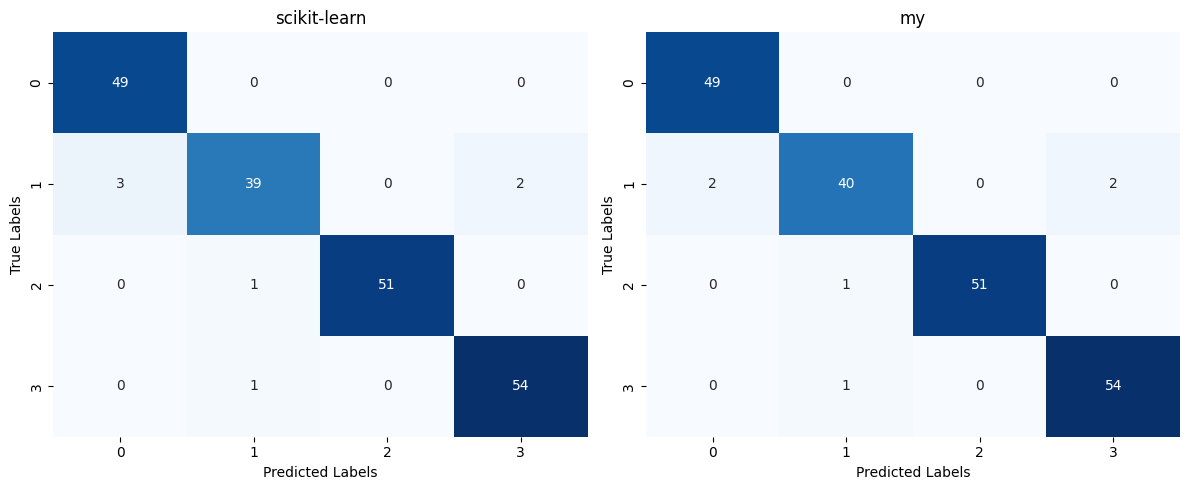

In [13]:
plot_confusion_matrices(predictions, y_test)

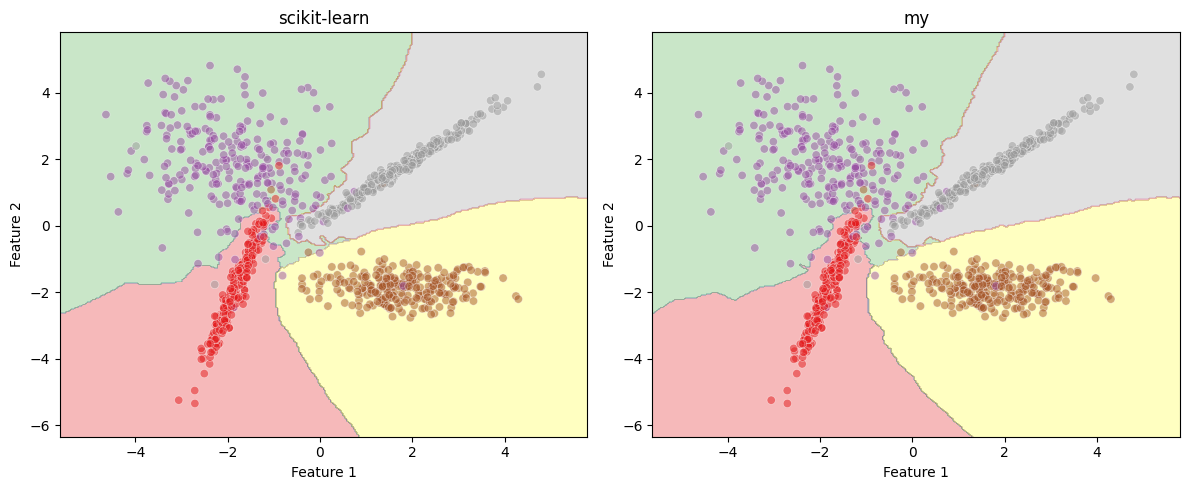

In [14]:
plot_classification_boundaries(models, X, y)